# 打开股票量化的黑箱(自己动手实现一个印钞机) 第一章

### 作者：阿布🐶

### 未经本人允许禁止转载

### 前言：


### 本文将全部使用python语音来做股票量化分析，涉及数据挖掘分析与机器学习方面知识，股票知识涉及的不多，本文涉及的策略都只是考虑单边做多不涉及做空。

### 关于量化的定义我不想从之前某本看过的书或者网络找来一段写上，事实上写这整篇文章我都尽量避免自己从任何之前看过的东西找来定义或者解释，我尽量使用大白话来说明一切，但是由于股票量化本身是个太庞大，细节非常多，知识体系也非常复杂的系统，所以一定会有恨多地方我将说不清楚，可以联系我，一起探讨，回到量化定义我的理解：通过对数据进行各种变换，分析股票时间序列数据，找到相对赢的概率大的特征，抽取特征组成规则，使用这个规则指导交易，其实我想说的就是找到一个方法炒股然后只赚不赔，哈哈，我下面会一步一步讲解到底如何做出这样的一个印钞机（看到这个词我就高兴😊）再次强调由于我无法解释所有细节，并且知识体系也确实需要很多，我不能保证你能全部看懂我下面再写一些什么，还是哪句话，我会留下微信，如有问题，可以联系我一起探讨（文章最后有微信号，如果能看到哪里再说吧）。
    

# 非均衡胜负收益带来的必然非均衡胜负比例，目标由因子的能力解决一部分，模式识别提升关键的一部分

**这个是这篇文章最核心的思想，原创，这一章开不会涉及，从下一章开始，其实整个文章我只是想解释这句话，前面要做一些必要铺垫，如果你有比较多的股票量化知识请忽略前面的章节，直接跳到核心章节，或者你也可以选择跳跃阅读，从第二章开始整个印钞机之旅**

___
## 一. 前奏开始

### 1. 数据系统 
        爬取或者购买数据，数据的实时度及精确性影响着你的系统实现, 一般不会只听信一个数据源，会有策略进行数据的准确性的校验
        
### 量化最根本的组成单元就是数据，没有数据一切扯淡，数据即是起点也会是最终的终点，数据的各种分析组合构成了量化的基础。对于股票的这个数据，它是由股票代码，股票价格，股票成交量，加上时间组成了一个庞大的四维空间，在这个空间中人们根据时间周期，行业类别，市值大小等等历史经验，客观事实又取舍空间中各个部分，提取压缩自己关心的数据，传统股票交易中，由于时间这个维度的客观存在及周期连续特性，时间这个维度很有可能被         一般交易者当作朋友，具体表现就是跌了不卖出股票，等待一段时间后，涨上去再卖出，但是它一定会涨上去吗，也许你的回答就是那就继续拿着吧，         但如果你要是做过美股期权交易，或者期货你就会发现多一个时间这个维度有多么的可怕，对整个交易系统带来多么大的改变，想想科幻小说三体中最后被二维化的地球吧，还有哪些进入4维碎片中的人类怎么形容4维的世界，在整个股票交易中所有的维度都不应该是朋友，但也不应该是敌人，量化的目标就是类似在这些复杂的维度中根据一定的方法降低空间复杂度需找特征，总结规律，指导交易


我再次强调，所有内容都为原创，我语言写作能力很一般，如果有说的不恰当的地方请您提出，我将感激不禁！

In [1]:
import ZEnv
import ZLog
import ZCommonUtil
import SymbolPd
import seaborn as sns
%matplotlib inline

makedirs data/DayKLine/2016-10-22


一般会按照你的交易系统来组织数据，这里只是简单举例

In [8]:
# 获取5年美股， 诺亚财富的数据
kl_pd = SymbolPd.make_kfold_pd('usNOAH', n_folds=5)
kl_pd.head()

,atr14,atr21,close,date,date_week,high,key,low,netChangeRatio,open,preClose,volume
2011-08-30,1.122806,1.085545,12.55,20110830,1,12.92,0,11.70,5.73,11.70,11.87,37580
2011-08-31,1.105463,1.075757,12.33,20110831,2,12.75,1,12.17,-1.75,12.47,12.55,61056
2011-09-01,1.062215,1.048340,12.30,20110901,3,12.50,2,12.05,-0.24,12.50,12.33,12412
2011-09-02,1.019914,1.020800,11.88,20110902,4,12.17,3,11.86,-3.41,12.00,12.30,9614
2011-09-06,1.010635,1.014571,11.61,20110906,1,11.83,4,11.41,-2.27,11.83,11.88,25212


如下表格看到分时数据的volume全是0吗，说明这个数据有问题，在你的系统中会有大量代码处理这种异常的，fill，merge数据这文章的核心不是这些东西，简单掠过

In [13]:
# 获取分时数据
kl_pd_minute = SymbolPd.make_kminute_foldpd('usNOAH', n_folds=5, period=1)
kl_pd_minute.tail()

,netChangeRatio,preClose,price,volume
2016-10-10 15:56:00,-0.711879,26.690001,26.5,0
2016-10-10 15:57:00,-0.711879,26.690001,26.5,0
2016-10-10 15:58:00,-0.711879,26.690001,26.5,0
2016-10-10 15:59:00,-0.711879,26.690001,26.5,0
2016-10-10 16:00:00,-0.711879,26.690001,26.5,0


所有数据在你的系统中不应该都是实时获取的，最少回归测试没有必要，一般会有全局缓存设置及各种缓存策略， 比如基本面数据对应一个股票一天只获取一次等等策略

In [79]:
# 基本面信息
SymbolPd.make_pd_info('usNOAH').ix[0]

NOAH info form Net


Avg_Daily_Volume            138362
EPS_Current_Year              1.76
EPS_Next_Year                 2.11
EPS_Next_Quarter                 0
Dividend_Yield                   0
Earnings_Share                1.58
Dividend_Share                   0
Dividend_Pay_Date         4/9/2013
52_weekLow                    20.3
52_weekHigh                  33.55
50_mv                        26.36
200_mv                       25.44
PE_Ratio                     15.68
PEG_Ratio                     0.71
PERatio_Real                   NaN
Price_EPS_Current_Year       14.03
Price_EPS_Next_Year           11.7
1yr_Target_Price                29
Name: NOAH, dtype: object

可视化数据

**数据是一切的基础，准确是首要要求，数据的封装目的是满足上层的需求，在有需求的前提下进行封装，
数据的可视化的目的是能快速的进行分析，不因该浪费过多的时间在可视化层面**

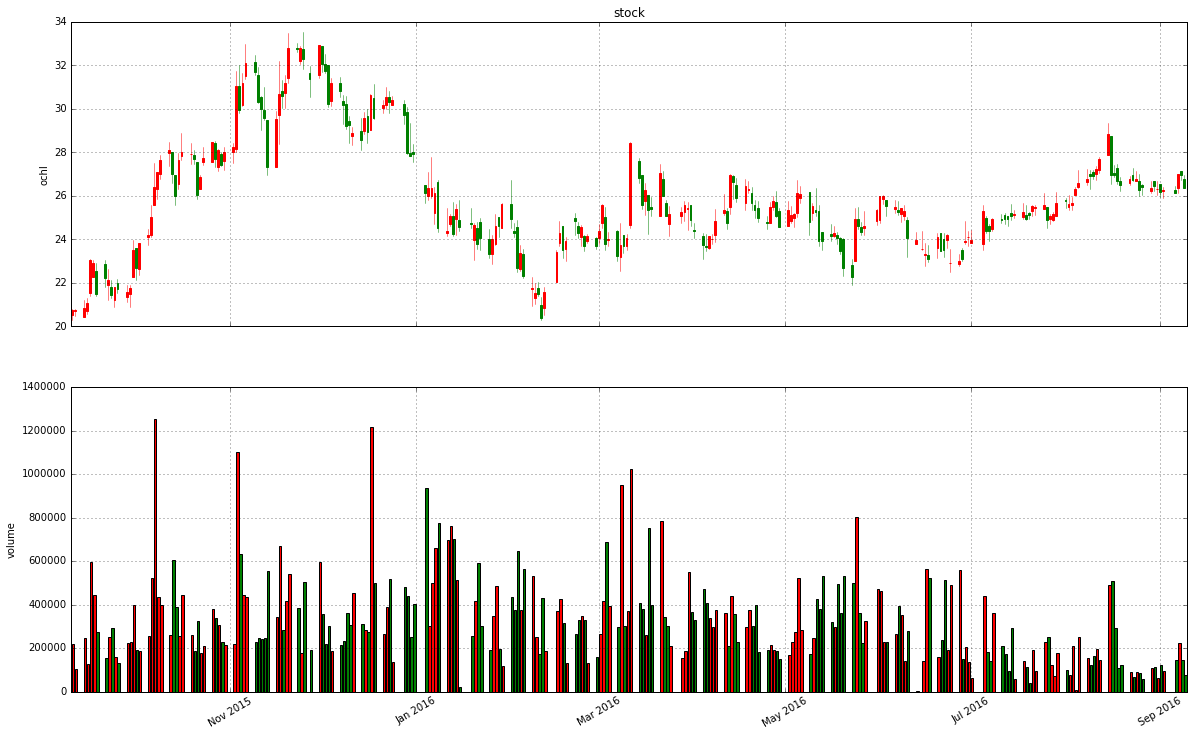

In [18]:
import MarketDrawer
MarketDrawer.plot_candle_form_klpd(kl_pd[-252:])

绘图在有交互需求的情况下一般会使用bokeh等高级库完成，不要在可视化上造轮子

In [21]:
MarketDrawer.plot_candle_form_klpd(kl_pd, html_bk=True)

![image](./Snip20160904_3.png) 

一般的实现需要支持从order中绘制，order是你的交易系统中对一次交易的定义，并可加入更多的标记，直观感受策略因子的问题及效果，保存在本地k线图进行深度学习后文会涉及

In [23]:
filter(lambda x: x.startswith('plot'), dir(MarketDrawer))

['plot_candle_form_klpd',
 'plot_candle_from_order',
 'plot_candle_from_symbol',
 'plot_candle_stick',
 'plot_html_symbol',
 'plot_minute_candle_from_klpd',
 'plot_minute_candle_from_symbol',
 'plot_simple_mul_stock',
 'plot_symbol']

### 人为的一些分类方式示例（选读与文章主题无关）：相同行业类别的股票

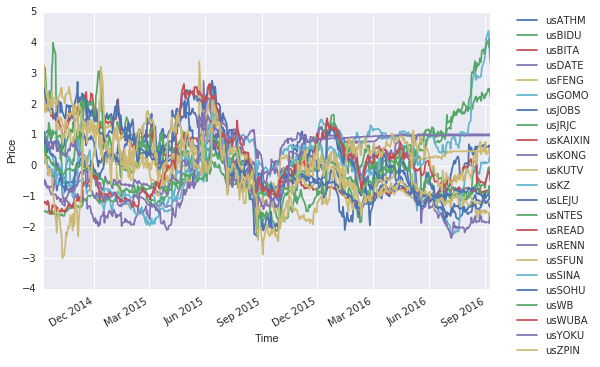

In [30]:
import IndustriesHelper
r_symbol = 'usSFUN'
# 这里获取了搜房相关中概股票组成pandas三维面板数据（这里无法对pandas等知识做基础说明，请阅读相关书籍）
pDate, pdata_it = IndustriesHelper.get_industries_panel_from_target(r_symbol, show=True)

按照需要，对数据进行的各种维度转换，规整是量化工作中最普遍的任务

In [4]:
change_m = pdata_it['netChangeRatio'].dropna(axis=1, how='all')
change_m = change_m.resample('M').mean().T
change_m.head(2)

,2014-09-30 00:00:00,2014-10-31 00:00:00,2014-11-30 00:00:00,2014-12-31 00:00:00,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,...,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2016-05-31 00:00:00,2016-06-30 00:00:00,2016-07-31 00:00:00,2016-08-31 00:00:00,2016-09-30 00:00:00
usATHM,-0.659333,1.049565,-0.979474,-0.734545,-0.0340,0.397368,0.720455,0.753810,-0.524,0.498182,...,0.672273,-1.775263,0.0170,0.65,0.294286,-0.821429,-0.962381,0.442,0.556957,-1.088333
usBIDU,-0.065333,0.420435,0.154211,-0.315000,-0.2105,-0.338421,0.115455,-0.158095,-0.060,0.045455,...,-0.632273,-0.726842,0.3725,0.45,0.097143,-0.363810,-0.240476,-0.156,0.311304,1.090000


更多关于数据请参考：[git地址](https://github.com/bbfamily/abu/blob/master/%E6%95%B0%E6%8D%AE%E8%8E%B7%E5%8F%96-ABU%E9%87%8F%E5%8C%96%E7%B3%BB%E7%BB%9F.ipynb) 

## 2.相关性与指标

* 皮尔逊相关性
* 斯皮尔曼秩相关性
* 皮尔逊sign相关性
* 时间线性加权相关性
* atr, obv, macd, rsi，布林带

### 相关在股票量化中是非常常用的工具，比如底层的beta中会使用它进行仓位控制，简单说你不能买太多走势那么相似的股票，风险太大（beta等概念下文会有）
### atr, obv, macd, rsi这些我不用说了吧，最基本的一些技术指标，其实现在的量化手段这些技术发出的信号在系统中的权重已经很低了，几乎对整个系统不会有太多干预，但这些是作为一个完整交易系统必备的一些手段，我会在适当的地方讲解几个有实际用途的信号产生器

如下绘制noah一年走势最相似的10个股票，以多进程的方式运行(由于量化分析中大多数都是cpu密集型运算，结合使用python这个环境一般会使用多进程方式，rolling=True 时间加权即时间约靠近的权重越大，E_CORE_TYPE_PEARS使用皮尔逊相关性)

[('usNOAH', 0.99999999999999944), ('usSINA', 0.50115160218662469), ('usLFC', 0.49707877817120616), ('usBLK', 0.49444104507989056), ('us.IXIC', 0.49378808088380705), ('usCTRP', 0.48953856607324903), ('us.INX', 0.47332792291463199), ('usAMG', 0.4724635324193146), ('usTROW', 0.47217524559060287), ('usLYV', 0.47054704272561693)]


************************************************************************************************************
show net cg ret...


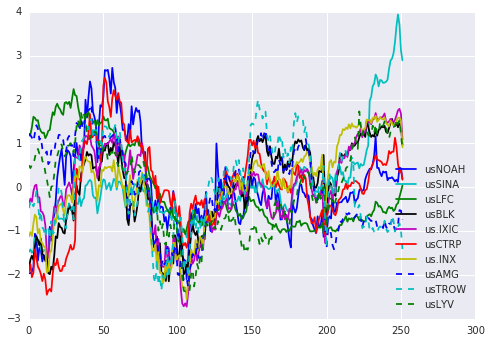

In [31]:

from SimilarHelper import find_similar_with_cnt, CoreCorrType, pd_list
net_cg_ret = find_similar_with_cnt('usNOAH', 252, show_cnt=10, how='process', rolling=True,
                          show=True, corr_type=CoreCorrType.E_CORE_TYPE_PEARS.value)

在相关性基础上量化应用举例

In [9]:
import TLineSimilar

**calc_similar_top** 

按照等权重的方式计算相关性排名, 显示对比中会按照look_max方式对齐数据

    sc=slice 采用那几种相关性度量方式
    slice(1, 2)：sperman ＋ pers sign
    slice(0, 1)：pers ＋  sperman
 
最后返回的结果是rank的结果，从2开始，1是symbol自身


###  简单的说就是综合几种相似度对比的方式，按照等权重方式在进行排序，得到一个综合相似度排名
### 如下所示与诺亚财富综合相似度最高的前三股票可视化显示

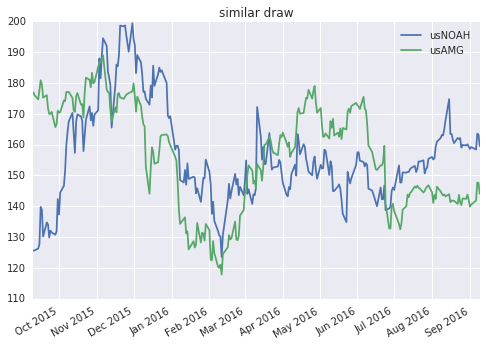

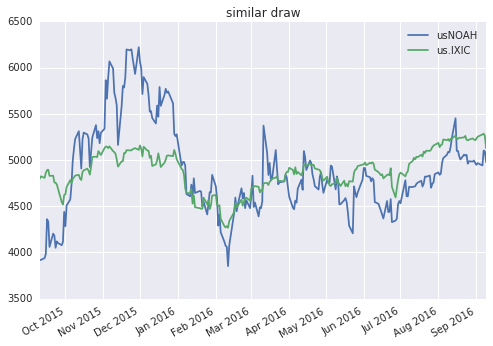

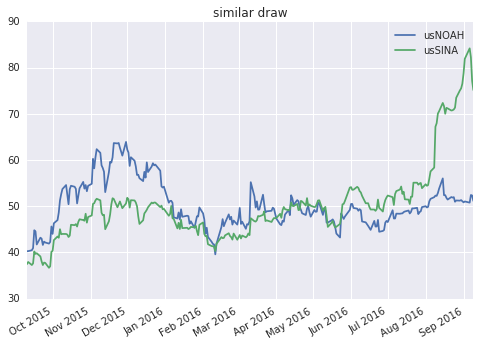

usAMG      2.0
us.IXIC    3.0
usSINA     4.0
dtype: float64

In [32]:
TLineSimilar.calc_similar_top('usNOAH', sc=slice(1, 2), show_cnt=3)

计算'usNOAH', 'usSFUN'与在所有股票中的相似度水平，及所有股票都会进行相似度计算，使用它们两个
的rank排名的小数表现形式作为结果，这就是量化的最一般应用**以数字的最终表现形式将维度及关系进行转换量化**

usNOAH similar rank scoreusSFUN :0.692


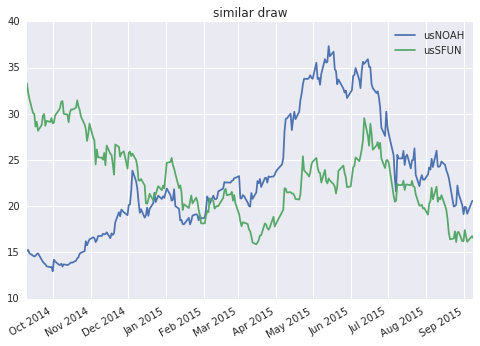

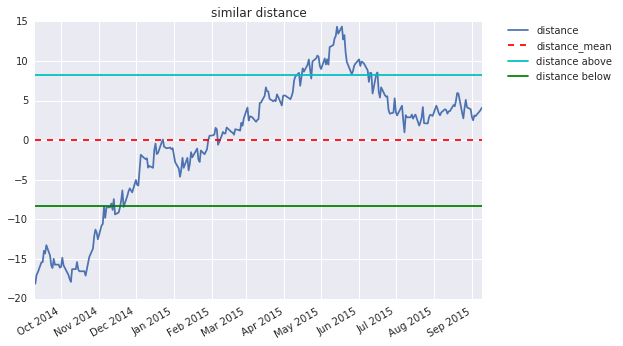

0.692

In [33]:
TLineSimilar.calc_similar('usNOAH', 'usSFUN')

### 在此基础上完成一个量化应用

**相关与协整技术分析**

协整的概念可以自行搜索

相关不一定协整
协整不一定相关

技术分析思路
从最相关的top n中寻找m个最协整的股票，现在的策略是从top 100多个
相关等权重中阀值0.08计算寻找最协整的10个股票，10个股票标准化后做
diff之后axis=1 轴上做sum，类似等权重投票机制成如

        distance_votes
        2015-07-27   -14.724491
        2015-07-28   -12.712066
        2015-07-29   -11.945266
        2015-07-30   -13.801350
        2015-07-31   -13.520431
        2015-08-03   -11.381343
        2015-08-04    -9.486645
        2015-08-05   -11.319338
        2015-08-06    -6.517725
        2015-08-07    -9.103014
        2015-08-10    -5.025694
        ......................

之后计算vote diff的above std， below std，mean,
可以根据above std， below std等作为交易信号，形成
策略因子的基础组成部份

### 简单说就从noah综合相关性最高的top100中寻找协整度最高的10个股票，然后运用投票机制，将它们合为一体，计算方差与期望，下图最后显示的那个有三条横行的图就是最终目的，你可以简单理解成费了半天劲就是为了得到这三条线，当股价触及最上方的线就卖，股价触及最下方的线就卖出，在中间区域就是盘整区域


### 更多关于TLineSimilar请自行阅读源代码，这里只为阐明量化最一般性工作流程

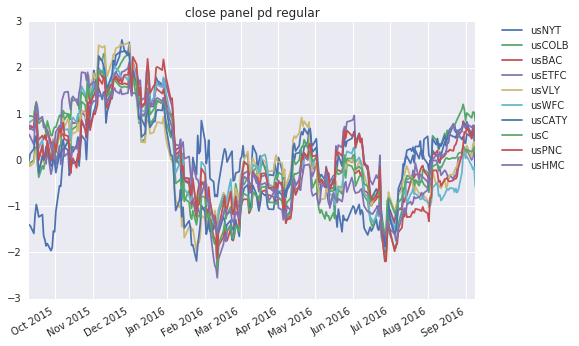

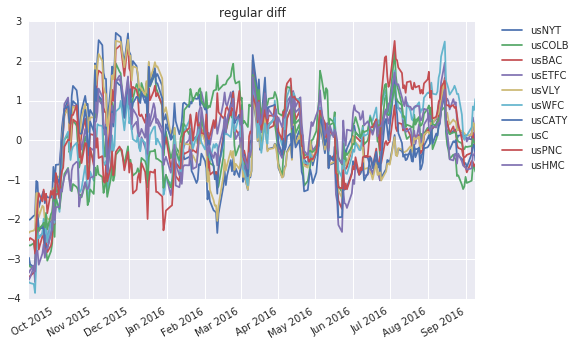

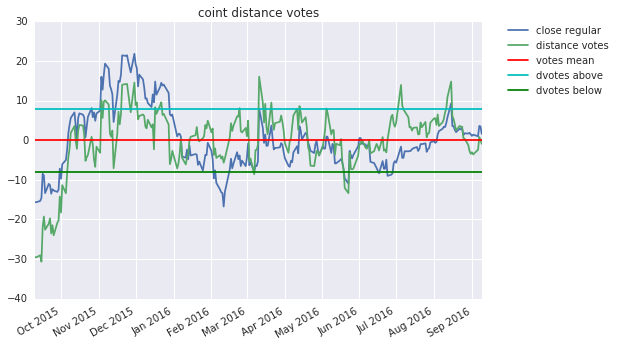

In [34]:
TLineSimilar.coint_similar('usNOAH')

**有点看不明白在说啥了吗？没关系，可以先向下看**
### 只要注意最后这个有三条线分割开的图，这就是最一般的量化分析寻找买入卖出点的结论图, 通过数据的技术分析，统计分析，基本面分析目的很多情况下就是找出这几个点作为信号，在你的交易系统上实现对信号的处理，交易系统可能是回测系统，也有可能是实盘系统，但他们都需要信号

更多相关与指标请参考：[git地址](https://github.com/bbfamily/abu/blob/master/%E7%9B%B8%E5%85%B3%E6%8C%87%E6%A0%87-ABU%E9%87%8F%E5%8C%96%E7%B3%BB%E7%BB%9F.ipynb) 

## 3. 基础交易

在数据和信号的前提下就可以开始做最简单的交易回测

In [17]:
from Capital import CapitalClass
from BuyBkFactor import BuyBkFactorClass
from SellBkFactor import SellBkFactorClass
from AlphaBSellMv import AlphaBSellMvEstimator
import Metrics

回测交易的基本组成：


### 1. alpha在因子层下面，负责整个交易大框架的盈利，负责相对激进部分，一般包括最高止盈，最高止损，最大跌幅止损，最大回撤止损等等
### 2. 因子作为组件插入alpha系统， 因子可以是简单因子只发现信号，也可以有自己的止盈止损等等规则
### 3. beta系统作为风险控制层在alpha底层，更高权限的对交易进行风险控制，一般比较谨慎的做出干预，大盘风险，组合的合理相关性等等


### 因子是量化中很重要的概念，它的好坏可以说是整个系统能否真正盈利的关键，alpha好比有宏图大志的ceo它的目标要挣钱要挣好多好多钱，但是它可能只在上层社会中寻找睁钱的大方向，不会涉及细节，beta好比保守的cfo它的首要任务是不能让公司垮掉，要控制最大的系统风险，factor就是具体的一个个的销售了，它们的销售业绩之接就是整个公司的盈利或者亏损，自己有对产品的完整控制权，但alpha或者beta时不时的要管它们，对它们指手画脚，但是他们必须听从他两个，一般来说cfo的权限会大于ceo但也有设计成cfo，ceo等权限的，factor的产品包装就是类似上面TLineSimilar的封装，如果感觉有点糊涂，先暂时跳过，现在不需要全部理解

{'stop_win_base_n': 3.0, 'stop_win': 10.818000369893834, 'mv_close_atr': 3.0, 'stop_loss': 7.2120002465958901, 'stop_loss_base_n': 2.0, 'mv_pre_atr': 1.5}
[{'draw': True, 'class': <class 'SellBkFactor.SellBkFactorClass'>, 'XD': 60}, {'draw': True, 'class': <class 'SellBkFactor.SellBkFactorClass'>, 'XD': 120}]
[{'draw': True, 'class': <class 'BuyBkFactor.BuyBkFactorClass'>, 'XD': 60}, {'draw': True, 'class': <class 'BuyBkFactor.BuyBkFactorClass'>, 'XD': 42}]


************************************************************************************************************
set(['usNOAH'])
simple profit: 36708.775
mean win profit 20248.8875
mean loss profit -8857.358
win rate 0.444444444444%


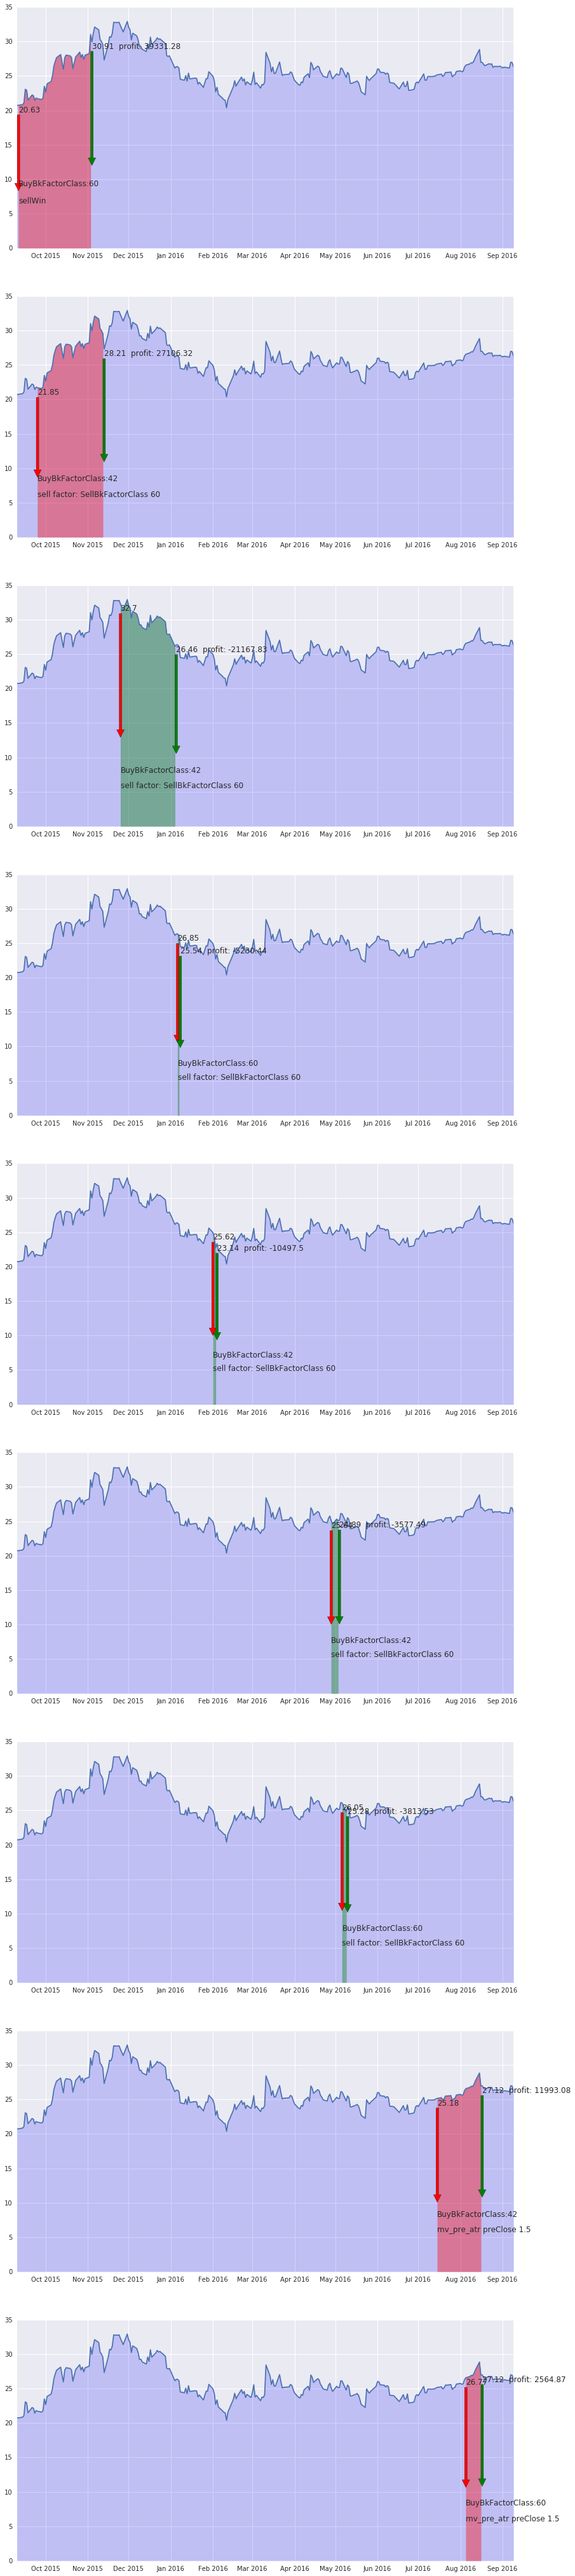

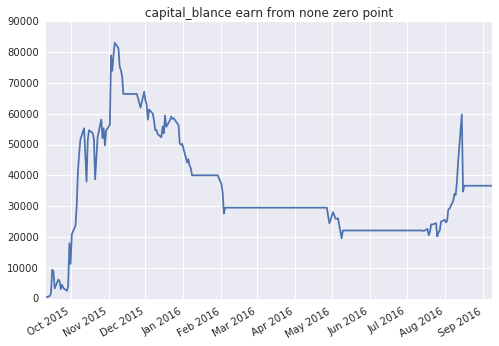

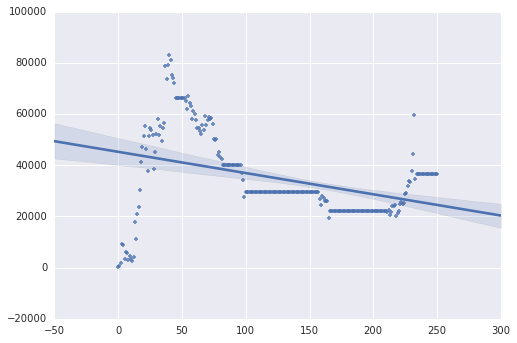

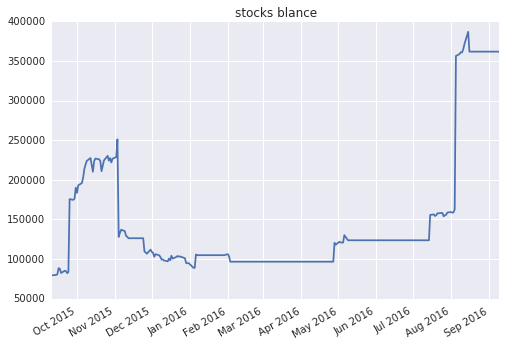

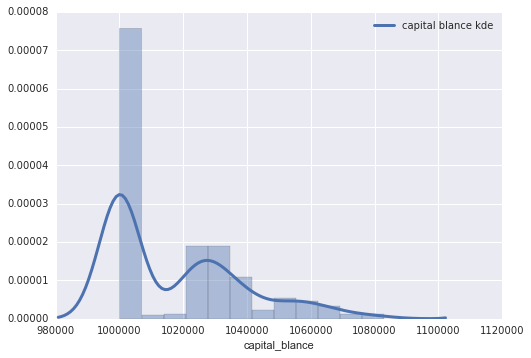

            buy Date  buy Price  buy Cnt            buyFactor Sell Date  \
2015-09-11  20150911     20.630     3826  BuyBkFactorClass:60  20151104   
2015-09-25  20150925     21.850     4262  BuyBkFactorClass:42  20151113   
2015-11-25  20151125     32.700     3395  BuyBkFactorClass:42  20160105   
2016-01-06  20160106     26.850     4008  BuyBkFactorClass:60  20160108   
2016-02-01  20160201     25.615     4250  BuyBkFactorClass:42  20160204   
2016-04-28  20160428     25.635     4802  BuyBkFactorClass:42  20160504   
2016-05-06  20160506     26.050     4985  BuyBkFactorClass:60  20160510   
2016-07-15  20160715     25.185     6182  BuyBkFactorClass:42  20160817   
2016-08-05  20160805     26.770     7225  BuyBkFactorClass:60  20160817   

            Sell Price Sell Type  Symbol  MaxLoss ExtraInfo  key    profit  \
2015-09-11      30.910       win  usNOAH    13.42      None  253  39331.28   
2015-09-25      28.210       win  usNOAH    14.64      None  263  27106.32   
2015-11-25     

{'stop_win_base_n': 3.0, 'stop_win': 88.43501816466744, 'mv_close_atr': 3.0, 'stop_loss': 58.95667877644496, 'stop_loss_base_n': 2.0, 'mv_pre_atr': 1.5}
[{'draw': True, 'class': <class 'SellBkFactor.SellBkFactorClass'>, 'XD': 60}, {'draw': True, 'class': <class 'SellBkFactor.SellBkFactorClass'>, 'XD': 120}]
[{'draw': True, 'class': <class 'BuyBkFactor.BuyBkFactorClass'>, 'XD': 60}, {'draw': True, 'class': <class 'BuyBkFactor.BuyBkFactorClass'>, 'XD': 42}]


************************************************************************************************************
set(['usGOOG'])
simple profit: -18648.1625
mean win profit 14056.125
mean loss profit -7793.40166667
win rate 0.25%


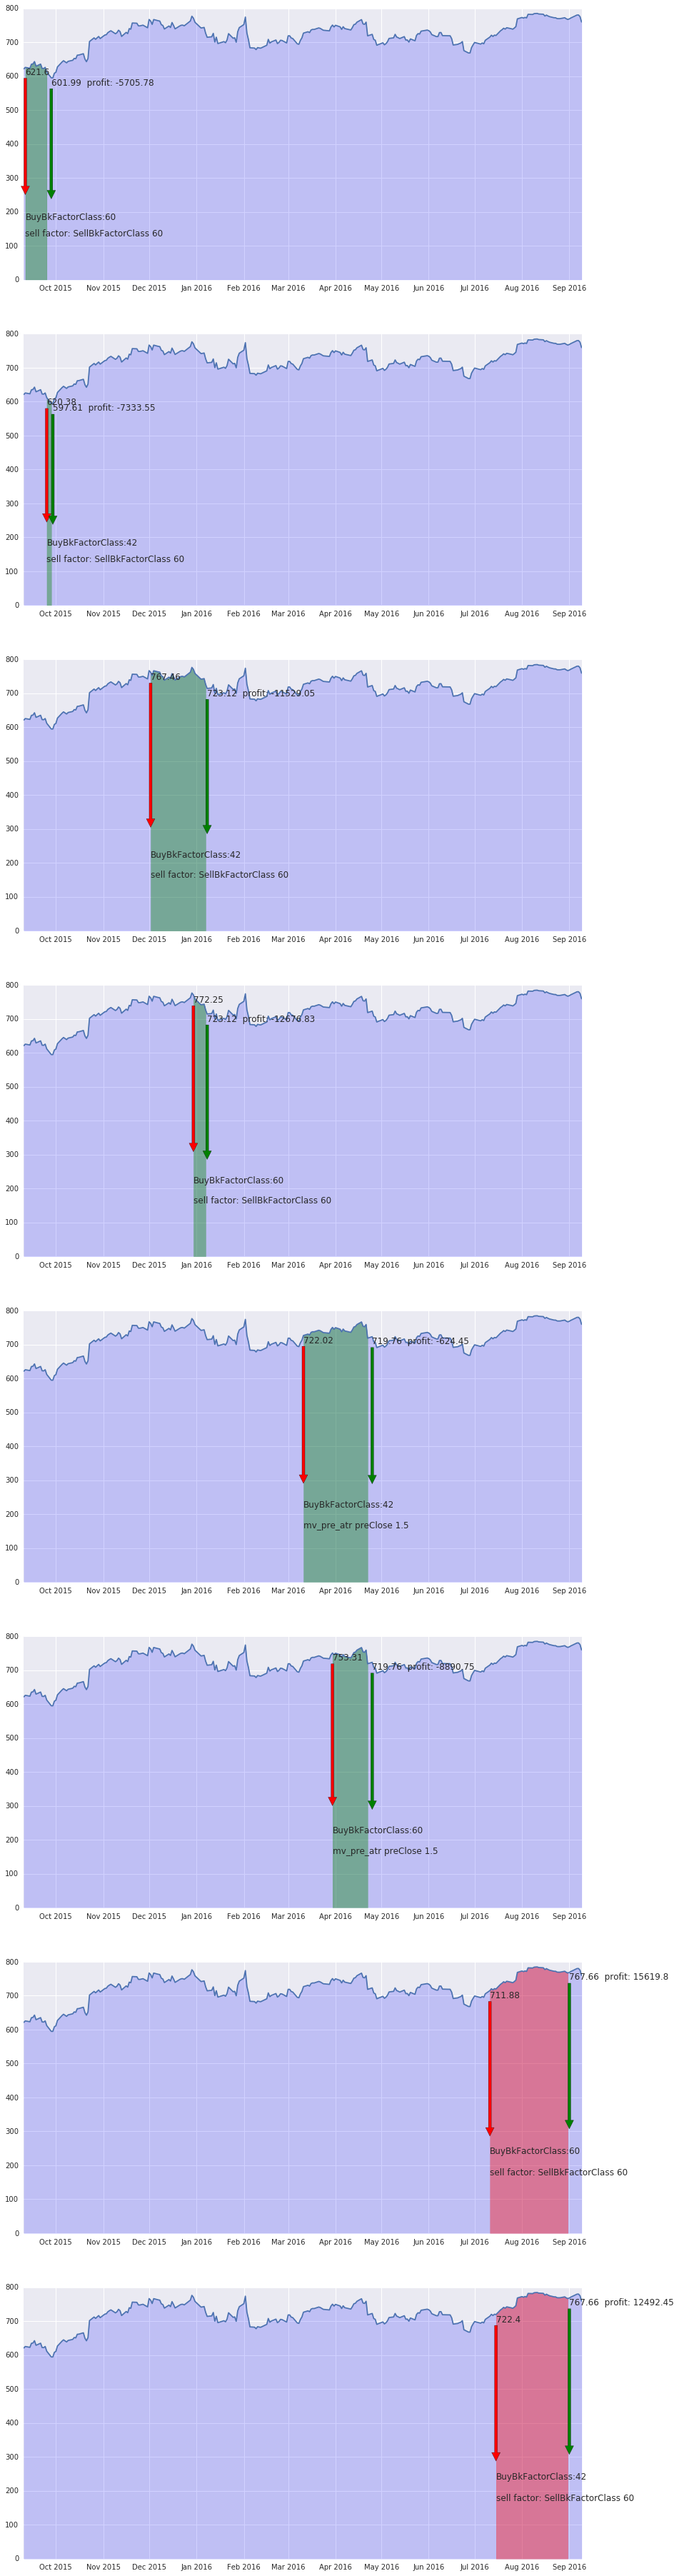

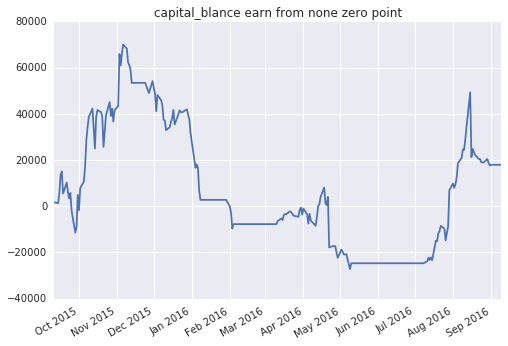

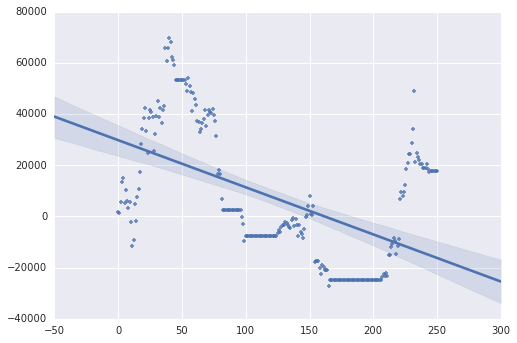

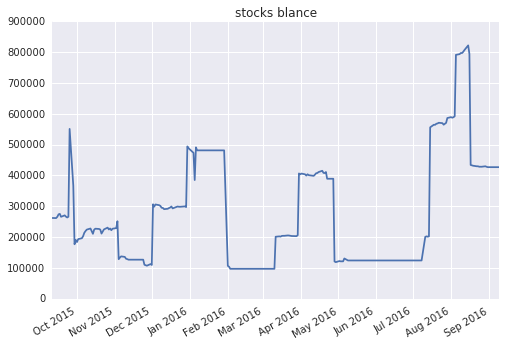

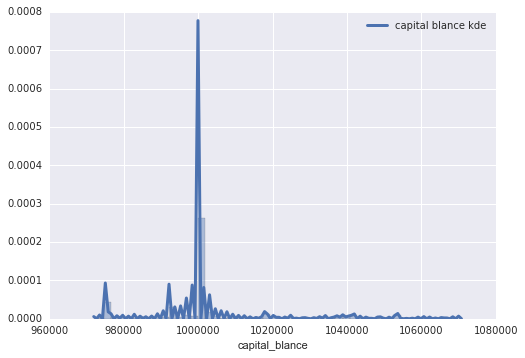

            buy Date  buy Price  buy Cnt            buyFactor Sell Date  \
2015-09-11  20150911   621.6000      291  BuyBkFactorClass:60  20150928   
2015-09-25  20150925   620.3850      322  BuyBkFactorClass:42  20150929   
2015-12-02  20151202   767.4575      260  BuyBkFactorClass:42  20160108   
2015-12-30  20151230   772.2500      258  BuyBkFactorClass:60  20160108   
2016-03-11  20160311   722.0225      276  BuyBkFactorClass:42  20160425   
2016-03-30  20160330   753.3100      265  BuyBkFactorClass:60  20160425   
2016-07-11  20160711   711.8750      280  BuyBkFactorClass:60  20160901   
2016-07-15  20160715   722.3975      276  BuyBkFactorClass:42  20160901   

            Sell Price Sell Type  Symbol  MaxLoss ExtraInfo  key    profit  \
2015-09-11    601.9925      loss  usGOOG   562.64      None  253  -5705.78   
2015-09-25    597.6100      loss  usGOOG   561.43      None  263  -7333.55   
2015-12-02    723.1150      loss  usGOOG   708.50      None  310 -11529.05   
2015-12-30  

In [35]:
# 设置aplha的参数
parameters = {
                  'stop_win_base_n'    : 3.0,
                  'stop_loss_base_n'   : 2.0,
                  'mv_close_atr': 3.0,
                  'mv_pre_atr'  : 1.5,
             }

# 构建因子 
# BuyBkFactorClass是向上突破xd天最高股价作为买入信号的因子
# SellBkFactorClass是向下突破xd天最低股价作为卖出信号的因子
buy_factors = [{'XD': 60, 'class': BuyBkFactorClass, 'draw': True},
               {'XD': 42, 'class': BuyBkFactorClass, 'draw': True}]

sell_factors = [{'XD': 60, 'class': SellBkFactorClass, 'draw': True}, 
                {'XD': 120, 'class': SellBkFactorClass, 'draw': True}]

target_symbols = ['usNOAH', 'usGOOG']
# 资金
cap = CapitalClass(1000000)

# 多个股票加载同样的n个因子运行回测
results, orders_pd, action_pd, all_fit_symbols = AlphaBSellMvEstimator.do_symbols_with_same_factors(target_symbols, buy_factors, sell_factors, parameters, cap,
                                                 scoring=Metrics.K_RMULT, show=True)

直观感觉上面那些交易图，通过分析生效因子及生效原因，**调整你的因子及底层模型，但要注意不要过拟合**，每个微调都不应该
只针对这次交易或者这个股票，归纳总结写出自己的有效因子，alpha是这阶段的目标

In [69]:
# 返回的交易数据
orders_pd.head()

,buy Date,buy Price,buy Cnt,buyFactor,Sell Date,Sell Price,Sell Type,Symbol,MaxLoss,ExtraInfo,key,profit,result,sell_type_extra,R
2015-09-11,20150911,20.630,3826,BuyBkFactorClass:60,20151104,30.9100,win,usNOAH,13.42,None,253,39331.28,1,sellWin,1.425798
2015-09-11,20150911,621.600,291,BuyBkFactorClass:60,20150928,601.9925,loss,usGOOG,562.64,None,253,-5705.78,-1,sell factor: SellBkFactorClass 60,-0.332556
2015-09-25,20150925,21.850,4262,BuyBkFactorClass:42,20151113,28.2100,win,usNOAH,14.64,None,263,27106.32,1,sell factor: SellBkFactorClass 60,0.882108
2015-09-25,20150925,620.385,322,BuyBkFactorClass:42,20150929,597.6100,loss,usGOOG,561.43,None,263,-7333.55,-1,sell factor: SellBkFactorClass 60,-0.386312
2015-11-25,20151125,32.700,3395,BuyBkFactorClass:42,20160105,26.4650,loss,usNOAH,25.49,None,306,-21167.83,-1,sell factor: SellBkFactorClass 60,-0.864771


In [70]:
# 返回的action数据
action_pd.head()

,Date,Price,Cnt,Symbol,action,deal
0,20150911,20.6300,3826,usNOAH,buy,True
1,20150911,621.6000,291,usGOOG,buy,True
2,20150925,620.3850,322,usGOOG,buy,True
3,20150925,21.8500,4262,usNOAH,buy,True
4,20150928,601.9925,291,usGOOG,sell,True


In [72]:
# 返回的资金情况数据
cap.capital_pd.tail()

,atr21,cash_blance,date,stocks_blance,usNOAH_keep,usNOAH_worth,capital_blance,usGOOG_keep,usGOOG_worth
2016-09-02,49.182904,1.017891e+06,20160902,0.0,0.0,0.0,1.017891e+06,0.0,0.0
2016-09-06,49.160004,1.017891e+06,20160906,0.0,0.0,0.0,1.017891e+06,0.0,0.0
2016-09-07,48.614813,1.017891e+06,20160907,0.0,0.0,0.0,1.017891e+06,0.0,0.0
2016-09-08,47.609250,1.017891e+06,20160908,0.0,0.0,0.0,1.017891e+06,0.0,0.0
2016-09-09,52.866810,1.017891e+06,20160909,0.0,0.0,0.0,1.017891e+06,0.0,0.0


**针对alpha会有很多参数需要，设置一般的做法是会首先针对alpha的参数做grid search，针对特定因子组合寻找最优参数，如下所示，量化中不管是使用凸优化还是模特卡洛分析还是grid search都会涉及到寻找最优参数，最优的定义一定要保证不能过拟合你的整个系统，也就是要做根据具体应用train test split, 并且需要有一套合理的scoring metrics 作为检验的标准**

In [37]:
import numpy as np
import GridHelper
from GridSearch import GridSearchCV

close_atr = np.arange(2.0, 4.0, 0.5)
pre_atr = np.arange(1.5, 3.0, 0.5)
win = np.arange(2.0, 4.0, 0.5)
loss = np.arange(0.5, 1.5, 0.5)
parameters = {
                  'stop_win_base_n'    : win,
                  'stop_loss_base_n'   : loss,
                  'mv_close_atr': close_atr,
                  'mv_pre_atr'  : pre_atr,
                  }

bk_days = [21, 42]
sell_bk_factor_grid = {
              'class': [SellBkFactorClass],
              'XD'   : bk_days,
              'draw'  : [True],
         }
bk_days2 = [60]
sell_bk_factor_grid2 = {
              'class': [SellBkFactorClass],
              'XD'   : bk_days2,
              'draw'  : [True],
         }
sell_factor_prams = GridHelper.gen_factor_grid(GridHelper.K_GEN_FACTOR_PARM_SELL, *[sell_bk_factor_grid, sell_bk_factor_grid2])


buy_bk_factor_grid = {
              'class': [BuyBkFactorClass],
              'XD'   : [60],
              'draw'  : [True],
         }
buy_bk_factor_grid2 = {
              'class': [BuyBkFactorClass],
              'XD'   : [120],
              'draw'  : [True],
         }
buy_factor_prams = GridHelper.gen_factor_grid(GridHelper.K_GEN_FACTOR_PARM_BUY, *[buy_bk_factor_grid, buy_bk_factor_grid2])
sell_factor_prams, buy_factor_prams, parameters

([[{'XD': 21, 'class': SellBkFactor.SellBkFactorClass, 'draw': True},
   {'XD': 60, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 42, 'class': SellBkFactor.SellBkFactorClass, 'draw': True},
   {'XD': 60, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 21, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 42, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 60, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  []],
 [[{'XD': 60, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True},
   {'XD': 120, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True}],
  [{'XD': 60, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True}],
  [{'XD': 120, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True}]],
 {'mv_close_atr': array([ 2. ,  2.5,  3. ,  3.5]),
  'mv_pre_atr': array([ 1.5,  2. ,  2.5]),
  'stop_loss_base_n': array([ 0.5,  1. ]),
  'stop_win_base_n': array([ 2. ,  2.5,  3. ,  3.5])})

In [ ]:
# 熟悉scikit的朋友一定对下面这种写法很熟悉，借鉴了scikit中很多实现的写法和方式
svr = AlphaBSellMvEstimator()
clf = GridSearchCV(svr, parameters, n_jobs=-1, 
                    scoring=[Metrics.K_QUANT, Metrics.K_RSMM, Metrics.K_SHARP, Metrics.K_RMULT], 
                    scoring_weight=[0.3, 0.2, 0.2, 0.3],
                    sell_factor_prams=sell_factor_prams)
clf.fit_with_buy_factor(cap, test_pd, kl_pd, buy_factor_prams, False)

更多基础交易相关请请参考：[git地址](https://github.com/bbfamily/abu/blob/master/%E5%9F%BA%E7%A1%80%E4%BA%A4%E6%98%93-ABU%E9%87%8F%E5%8C%96%E7%B3%BB%E7%BB%9F.ipynb) 

## 4. 理论基础

        类似物理有基础理论物理，基础物理构成应用物理等实用技术
        量化系统中构成因子等信号触发器的基础理论技术分析叫做基础技术

基于vwap

***vwap n日成交量于n日成交均价除总量，计算出n日均线，以std作为波动信号（类似boll）vwap_mean = (kl_pd.volume * uq_close).sum() / kl_pd.volume.sum()**

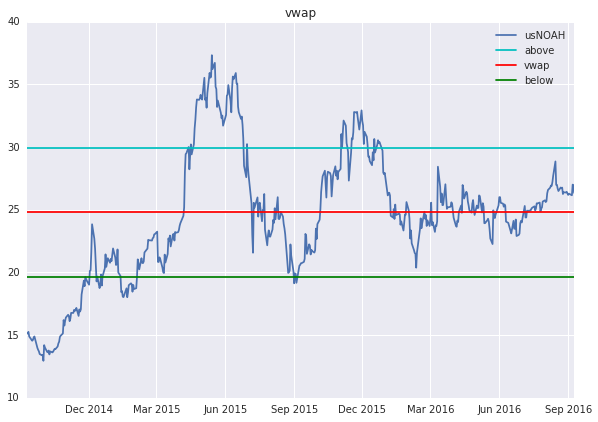

vwap(below=19.66000424364312, vwap=24.801009245012615, above=29.94201424638211)

In [41]:
import TLineVwap
TLineVwap.calc_vwap(kl_pd)

**跳空**

跳空阀值不是取的固定值: 根据每个月的波动率以时间加权计算跳空阀值, 详情看calc_jump具体实现计算每个缺口的强度，记录当前调空阀值, 方向等信息	
代码详情请自行查阅源代码TLineGolden.py 关键代码如下所示:

In [78]:
def calc_jump(kl_pd, show=True):
    """
        要使用np.abs(klPd['netChangeRatio'])去计算每个月的跳空阀值
    """
    kl_pd['abs_netChangeRatio'] = np.abs(kl_pd['netChangeRatio'])
    xd_mean = kl_pd.resample('21D').mean()
    net_change_ratio_mean = xd_mean['abs_netChangeRatio']
    volume_mean = xd_mean['volume']
    net_change_ratio_min = kl_pd['abs_netChangeRatio'].mean()
    """
        last_match_index只是为了提速
    """
    last_match_index = 0
    jump_pd = pd.DataFrame()
    for kl_index in np.arange(0, kl_pd.shape[0]):
        today = kl_pd.iloc[kl_index]

        if today.abs_netChangeRatio <= net_change_ratio_min:
            """
                只处理满足最小幅度的，也可提速
            """
            continue
        while net_change_ratio_mean.shape[0] > last_match_index \
                and kl_pd.index[kl_index] > net_change_ratio_mean.index[last_match_index]:
            last_match_index += 1

        if net_change_ratio_mean.shape[0] == last_match_index:
            """
                到最后了，倒回去一个，可优化代码
            """
            last_match_index -= 1

        if volume_mean[last_match_index] > today.volume:
            """
                首先量不达标的先排除了
            """
            continue

        jump_threshold = np.abs(net_change_ratio_mean[last_match_index])

        if today.preClose == 0 or jump_threshold == 0:
            continue

        # jump_threshold跳口的百分比, jump_diff需要调控的距离
        jump_diff = today.preClose * jump_threshold / 100
        if today.netChangeRatio > 0 and (today.low - today.preClose) > jump_diff:
            # if today.netChangeRatio > jump_threshold:
            """
                向上跳空 1
            """
            today['jump'] = 1
            today['jump_threshold'] = jump_threshold
            today['jump_diff'] = jump_diff
            """
                计算出跳空缺口强度
            """
            today['jump_power'] = (today.low - today.preClose) / jump_diff
            jump_pd = jump_pd.append(today)
        # elif (-today.netChangeRatio) > jump_threshold:
        elif today.netChangeRatio < 0 and (today.preClose - today.high) > jump_diff:
            """
                向下跳空 －1
            """
            today['jump'] = -1
            today['jump_threshold'] = jump_threshold
            today['jump_diff'] = jump_diff
            today['jump_power'] = (today.preClose - today.high) / jump_diff
            jump_pd = jump_pd.append(today)

    if show:
        MarketDrawer.plot_candle_form_klpd(kl_pd, view_indexs=jump_pd.index)
    return jump_pd

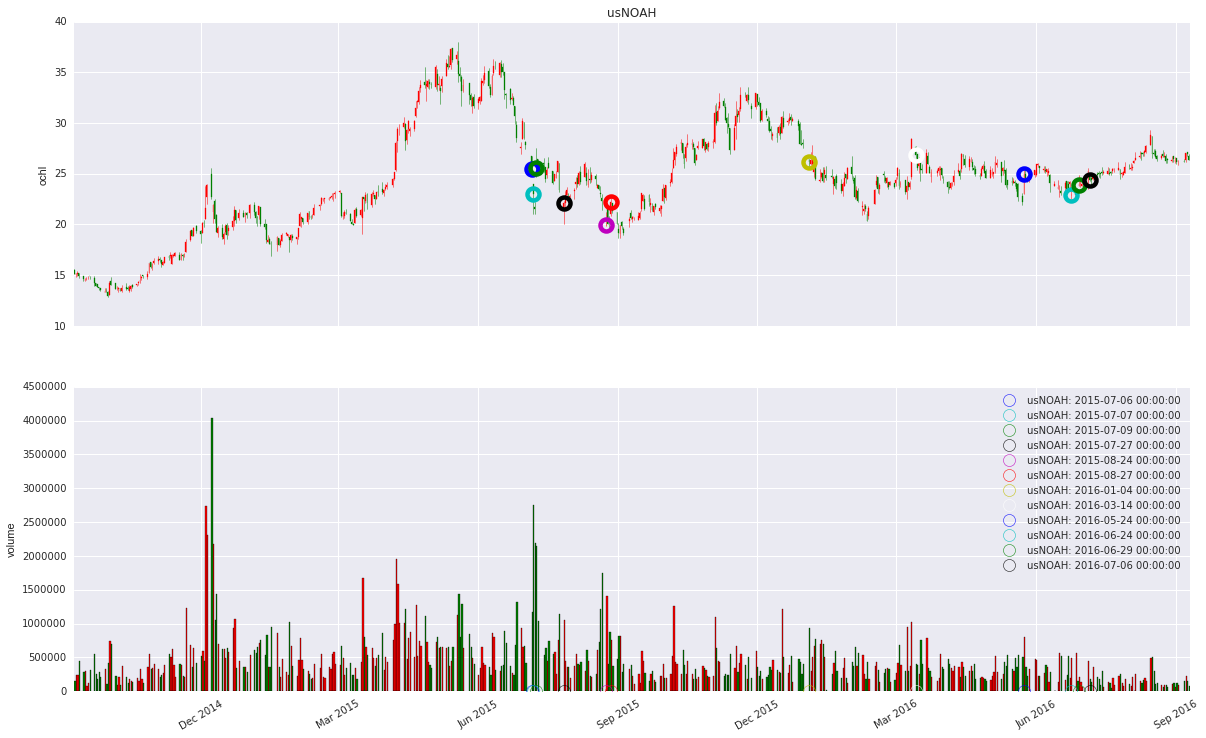

In [46]:
import TLineJump
jumps = TLineJump.calc_jump(kl_pd, True)

In [47]:
jumps.filter(['jump', 'jump_diff', 'jump_power', 'jump_threshold', 'netChangeRatio'])

,jump,jump_diff,jump_power,jump_threshold,netChangeRatio
2015-07-06,-1.0,1.018221,1.070494,3.662667,-8.27
2015-07-07,-1.0,0.933980,1.595323,3.662667,-9.88
2015-07-09,1.0,0.790037,3.961839,3.662667,18.45
2015-07-27,-1.0,0.801216,1.310508,3.424000,-5.30
2015-08-24,-1.0,0.674113,1.616939,3.024286,-10.45
2015-08-27,1.0,0.609394,1.115863,3.024286,10.32
2016-01-04,-1.0,0.610071,2.343989,2.184286,-6.41
2016-03-14,-1.0,0.654648,1.023451,2.302667,-5.59
2016-05-24,1.0,0.365223,1.971398,1.640714,12.08
2016-06-24,-1.0,0.186817,3.532870,0.771333,-5.45


#### 应用举例，fiter出合适做为信号触发器的跳空点
**跳口power > 2.0的组成namedtuple jump array
        接口不考虑跳空时间权重**

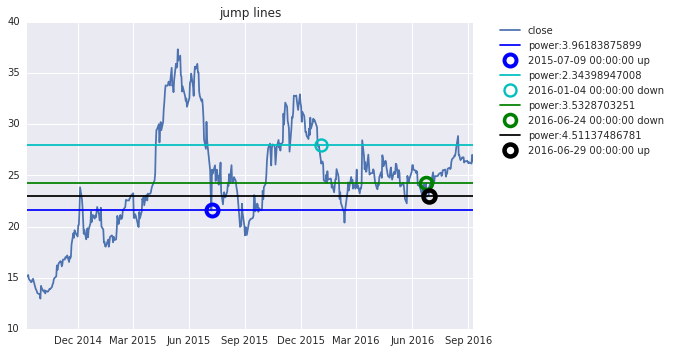

[jump(date=Timestamp('2015-07-09 00:00:00'), direction=1.0, power=3.9618387589850186, price=21.57),
 jump(date=Timestamp('2016-01-04 00:00:00'), direction=-1.0, power=2.3439894700780726, price=27.93),
 jump(date=Timestamp('2016-06-24 00:00:00'), direction=-1.0, power=3.532870325102579, price=24.219999999999999),
 jump(date=Timestamp('2016-06-29 00:00:00'), direction=1.0, power=4.511374867807322, price=22.989999999999998)]

In [49]:
TLineJump.calc_jump_line(kl_pd)

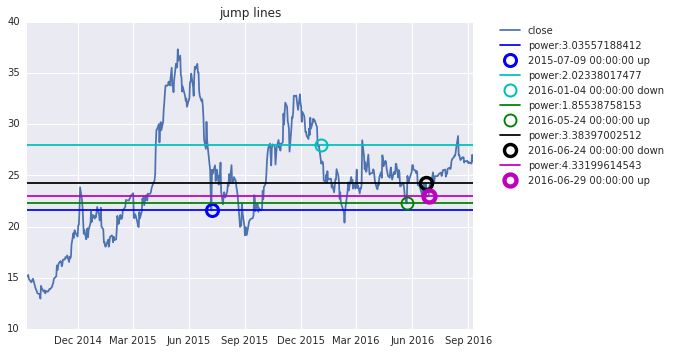

[jump(date=Timestamp('2015-07-09 00:00:00'), direction=1.0, power=3.0355718841209267, price=21.57),
 jump(date=Timestamp('2016-01-04 00:00:00'), direction=-1.0, power=2.0233801747671949, price=27.93),
 jump(date=Timestamp('2016-05-24 00:00:00'), direction=1.0, power=1.8553875815265513, price=22.260000000000002),
 jump(date=Timestamp('2016-06-24 00:00:00'), direction=-1.0, power=3.3839700251181362, price=24.219999999999999),
 jump(date=Timestamp('2016-06-29 00:00:00'), direction=1.0, power=4.3319961454292972, price=22.989999999999998)]

In [50]:
# 组成namedtuple jump array 接口考虑跳空时间权重:使用线性时间权重分配sw[1]给予的权重
TLineJump.calc_jump_line_weight(kl_pd, sw=(0.6, 0.4))

跳空应用2 

在某个因子中首先做全量股票n年数据回归，记录diff_days 上次跳空距离买入的时间，跳空强度jump_power
做成大量有结果的数据，之后使用适当的机器学习技术分析拟合数据，学习成果融于因子中

**更多请参看 机器学习部分**

In [57]:
import pandas
pandas.options.display.max_columns = 100
last_test_pd = ZCommonUtil.load_hdf5(ZEnv.g_project_root + '/data/cache/golden_n6_ma5cross_use_last_test', 'golden_n6_ma5cross_use_last_test')
last_test_pd.tail(2)

,buy Date,buy Price,buy Cnt,buyFactor,Sell Date,Sell Price,Sell Type,Symbol,MaxLoss,ExtraInfo,key,profit,result,sell_type_extra,R,sharpe,profit_cg,profit_cg_hunder,keep_days,lowBkCnt,his_miss_days,atr_std,deg_hisWindowPd,deg_windowPd,deg_60WindowPd,jump_power,diff_days,wave_score1,wave_score2,wave_score3,symbol_index
2012-07-09,20120709,22.450,8908,BuyGoldenFactorClass:42,20120718,23.535,win,usPFX,20.56,"{'wave_score3': -0.13571900892464062, 'wave_sc...",494,9665.18,1,BuyGoldenFactorClass:42: winPrice :above950,0.574074,2.926046,0.048330,4.832962,9,1,0,0.194435,5.433525,-0.246985,-1.826886,3.713055,248,0.091794,-0.011893,-0.135719,6
2012-07-10,20120710,4.215,27213,BuyGoldenFactorClass:42,20120718,4.045,loss,usTNK,2.72,"{'wave_score3': -0.5002471533628261, 'wave_sco...",495,-4626.21,-1,BuyGoldenFactorClass:42: lossPrice :below250,-0.113712,-3.666667,-0.040332,-4.033215,8,1,0,-0.085967,-15.921437,-2.619899,-13.806534,4.852371,152,-0.045329,-0.219426,-0.500247,6


**趋势**

        拟合趋势线寻找支撑阻力
        对股票‘技术分析’很熟悉的朋友👬们对
        上升趋势线，下降趋势线，阻力线, 支撑线

        这些概念很熟悉，但是从理论出发，
        很难有两个人画出的线是完全一样的，即是是一个人
        不同的时候去画也会有精度的误差，使用数据分析自己
        画出趋势与阻力是对量化分析的最根本诠释，人对数据的敏感度
        一定不如死的机器，
 
### 人是有感情的
        
      
### 也许你会画出自己想要的趋势线阻力线来骗自己，再坚持一下马上就阻力了就上去了等等，快交给机器吧！别自己画了！

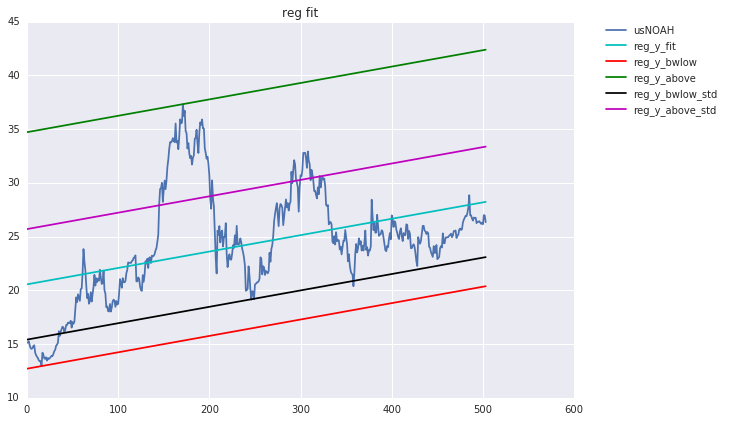

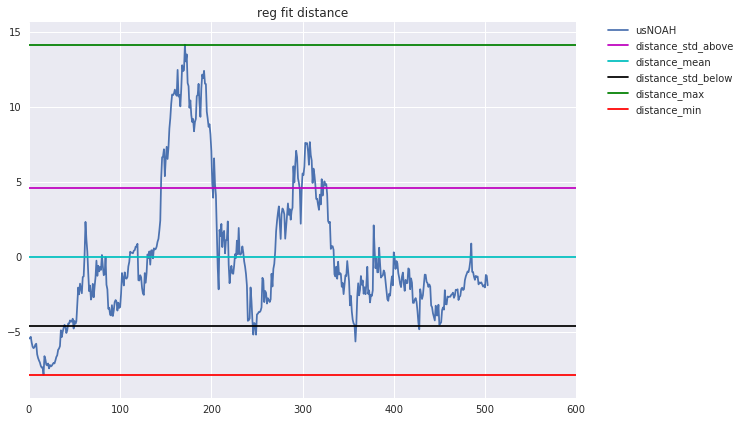

reg_fit(now=-1.8882674838912408, mean=2.1992989440193578e-15, above=4.6314808634245717, below=-4.6314808634245681, distance_max=14.156795957244121, distance_min=-7.8484906892137687)

In [58]:
import TLineTrend
TLineTrend.calc_reg_fit(kl_pd)

**黄金分割**

综合两种黄金切割方式，根据应用使用
maximum，minimum进行选择重点说一下这个，下面的例子都是使用这个策略组成的因子做的扩展
黄金分割一种是视觉上的382，618，一种就是统计上的382，618
如下代码所示：

In [ ]:
def find_golden_point_ex(x_org, y_org, show=False):
    sp382 = stats.scoreatpercentile(y_org, 38.2)
    sp618 = stats.scoreatpercentile(y_org, 61.8)
    sp50 = stats.scoreatpercentile(y_org, 50.0)

    if show:
        x_org = np.array(x_org)
        sp382_list = [[x_org.min(), x_org.max()], [sp382, sp382]]
        sp618_list = [[x_org.min(), x_org.max()], [sp618, sp618]]
        sp50_list = [[x_org.min(), x_org.max()], [sp50, sp50]]

        TLineDrawer.plot_xy_with_other_x_y(x_org, y_org, '-', sp382_list, sp50_list, sp618_list)
    return sp382, sp50, sp618


def find_golden_point(x_org, y_org, show=False):
    cs_max = y_org.max()
    cs_min = y_org.min()

    sp382 = (cs_max - cs_min) * 0.382 + cs_min
    sp618 = (cs_max - cs_min) * 0.618 + cs_min
    sp50 = (cs_max - cs_min) * 0.5 + cs_min
    if show:
        x_org = np.array(x_org)
        sp382_list = [[x_org.min(), x_org.max()], [sp382, sp382]]
        sp618_list = [[x_org.min(), x_org.max()], [sp618, sp618]]
        sp50_list = [[x_org.min(), x_org.max()], [sp50, sp50]]

        TLineDrawer.plot_xy_with_other_x_y(x_org, y_org, '-', sp382_list, sp50_list, sp618_list)
    return sp382, sp50, sp618


In [80]:
def calc_golden(kl_pd, show=True, only_be=False):
    dk = True if kl_pd.columns.tolist().count('close') > 0 else False
    uq_close = kl_pd.close if dk else kl_pd.price

    if not hasattr(kl_pd, 'name'):
        kl_pd.name = 'unknown'

    g_382, g_500, g_618 = TLineAnalyse.find_golden_point(kl_pd.index, uq_close)
    if show and not only_be:
        plt.axes([0.025, 0.025, 0.95, 0.95])
        plt.plot(uq_close) if dk else plt.plot(uq_close.values)
        plt.axhline(g_618, color='c')
        plt.axhline(g_500, color='r')
        plt.axhline(g_382, color='g')
        _ = plt.setp(plt.gca().get_xticklabels(), rotation=30)
        plt.legend([kl_pd.name, 'g618', 'g500', 'g382'])
        plt.title('mean golden')
        plt.show()

    gex_382, gex_500, gex_618 = TLineAnalyse.find_golden_point_ex(kl_pd.index, uq_close)
    if show and not only_be:
        plt.axes([0.025, 0.025, 0.95, 0.95])
        plt.plot(uq_close) if dk else plt.plot(uq_close.values)
        plt.axhline(gex_618, color='c')
        plt.axhline(gex_500, color='r')
        plt.axhline(gex_382, color='g')
        _ = plt.setp(plt.gca().get_xticklabels(), rotation=30)
        plt.legend([kl_pd.name, 'gex618', 'gex500', 'gex382'])
        plt.title('median golden')
        plt.show()

    above618 = np.maximum(g_618, gex_618)
    below618 = np.minimum(g_618, gex_618)
    above382 = np.maximum(g_382, gex_382)
    below382 = np.minimum(g_382, gex_382)

    percents = [0.20, 0.25, 0.30, 0.70, 0.80, 0.90, 0.95]
    # precents = np.linspace(0.0, 1.0, 0.05)
    pts_dict = TLineAnalyse.find_percent_point(percents, uq_close)

    # import pdb
    # pdb.set_trace()
    below200 = np.minimum(*pts_dict[0.20])
    below250 = np.minimum(*pts_dict[0.25])
    below300 = np.minimum(*pts_dict[0.30])

    above700 = np.maximum(*pts_dict[0.70])
    above800 = np.maximum(*pts_dict[0.80])
    above900 = np.maximum(*pts_dict[0.90])
    above950 = np.maximum(*pts_dict[0.95])

    if show:
        plt.axes([0.025, 0.025, 0.95, 0.95])
        plt.plot(uq_close) if dk else plt.plot(uq_close.values)

        plt.axhline(above950, lw=3.5, color='c')
        plt.axhline(above900, lw=3.0, color='y')
        plt.axhline(above800, lw=2.5, color='k')
        plt.axhline(above700, lw=2.5, color='m')

        plt.axhline(above618, lw=2, color='r')
        plt.axhline(below618, lw=1.5, color='r')
        plt.fill_between(kl_pd.index, above618, below618,
                         alpha=0.1, color="r")

        '''
            *************I AM HERE*************
        '''
        plt.axhline(above382, lw=1.5, color='g')
        plt.axhline(below382, lw=2, color='g')
        plt.fill_between(kl_pd.index, above382, below382,
                         alpha=0.1, color="g")

        plt.axhline(below300, lw=2.5, color='k')
        plt.axhline(below250, lw=3.0, color='y')
        plt.axhline(below200, lw=3.5, color='c')

        _ = plt.setp(plt.gca().get_xticklabels(), rotation=30)
        plt.legend([kl_pd.name, 'above950', 'above900', 'above800', 'above700', 'above618', 'below618',
                    'above382', 'below382', 'below300', 'below250', 'below200'], bbox_to_anchor=(1.05, 1), loc=2,
                   borderaxespad=0.)
        plt.title('between golden')
        plt.show()

    return namedtuple('golden', ['g382', 'gex382', 'g500', 'gex500', 'g618',
                                 'gex618', 'above618', 'below618', 'above382', 'below382',
                                 'above950', 'above900', 'above800', 'above700', 'below300', 'below250', 'below200'])(
        g_382, gex_382,
        g_500, gex_500, g_618, gex_618, above618, below618, above382, below382,
        above950, above900, above800, above700, below300, below250, below200)

它们组成的因子联合使用了这两种，如下图所示，配合其它位置做成弹力
止盈止损策略，简单的说就是比如我在below382和above382之间
再满足一些条件比如ma5 > ma10作为买入信号, 如果股价下跌到below200我的最高止盈
也随着下降一个档，如果股价上升一个档，最低止损也上升一个档位，直至
向上或者向下击穿止最后一个止盈止损位

代码详情请自行查阅源代码：TLineGolden

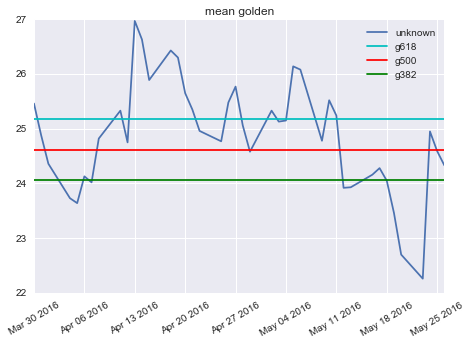

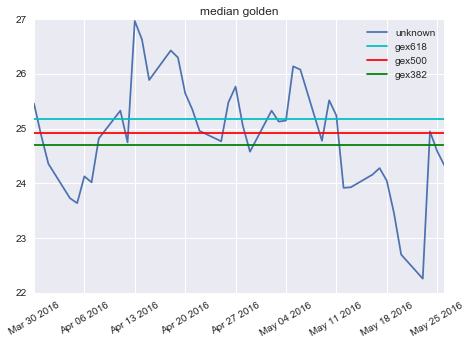

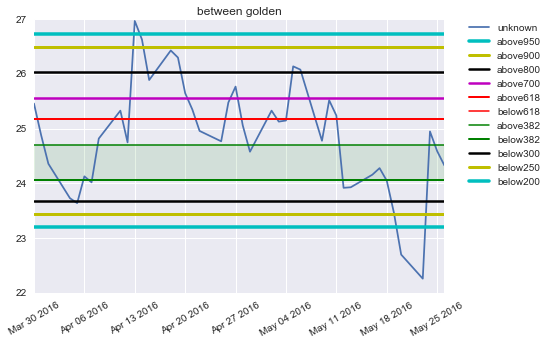

In [9]:
golden = TLineGolden.calc_golden(kl_pd)

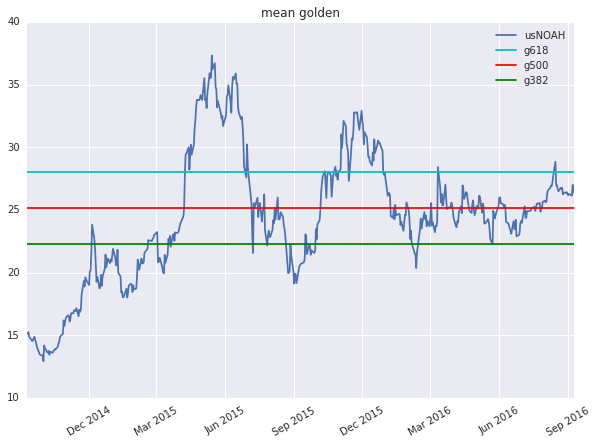

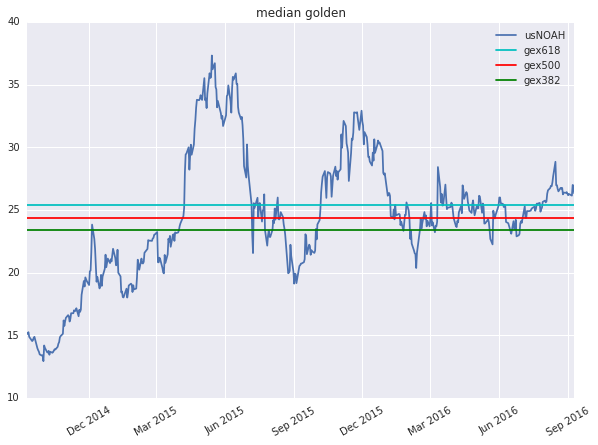

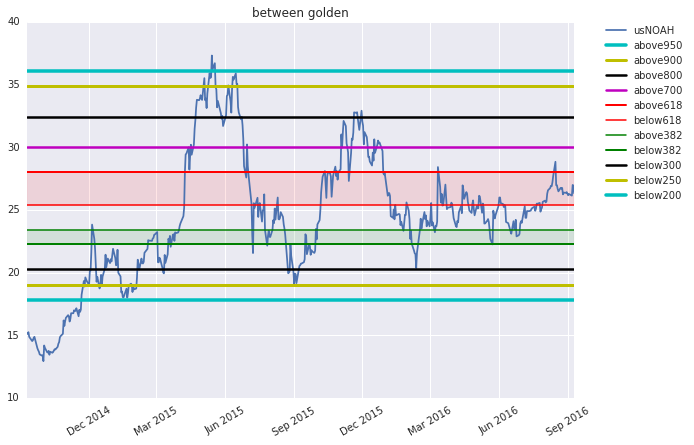

golden(g382=22.259340000000002, gex382=23.382919999999999, g500=25.134999999999998, gex500=24.379999999999999, g618=28.010660000000001, gex618=25.377079999999999, above618=28.010660000000001, below618=25.377079999999999, above382=23.382919999999999, below382=22.259340000000002, above950=36.101500000000001, above900=34.882999999999996, above800=32.445999999999998, above700=30.009, below300=20.260999999999999, below250=19.0425, below200=17.823999999999998)

In [59]:
import TLineGolden
TLineGolden.calc_golden(kl_pd)

更多基础理论信号请请参考：[git地址](https://github.com/bbfamily/abu/blob/master/%E7%90%86%E8%AE%BA%E5%9F%BA%E7%A1%80-ABU%E9%87%8F%E5%8C%96%E7%B3%BB%E7%BB%9F.ipynb)

啰啰嗦嗦说到这里您能可能还有很多地方不明白，没关系这章内容是铺垫，而且手法不一定非是这样，您只要知道如下就可以继续阅读下一章节

### 1. 获取数据为技术分析做基础，技术分析是因子的基础
### 2. 因子是整个系统能否盈利的关键，alpha与beta＋factor是一个系统关键
### 3. 我们之后的章节使用黄金分割线因子做为demo，黄金分割的股票意义

## 感谢🙏您能有耐心看到这里
## 如果有什么问题可以加阿布的微信 
## 微信号：aaaabbbuu

![image](./mmexport1475383814280.jpg)